## Co-refinement of multiple contrast datasets

A demonstration of how to do co-refinement of several datasets with *refnx*.

In [1]:
%matplotlib inline
import os.path

from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective, Parameter
from refnx.reflect import SLD, ReflectModel
import refnx

import scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(f'refnx: {refnx.version.version}\nscipy: {scipy.version.version}\nnumpy: {np.version.version}')

refnx: 0.1.25.dev0+3805297
scipy: 1.7.1
numpy: 1.20.3


These are datasets used in refnx testing, distributed with every refnx install.

In [3]:
pth = os.path.dirname(refnx.__file__)

e361 = ReflectDataset(os.path.join(pth, 'analysis', 'test', 'e361r.txt'))
e365 = ReflectDataset(os.path.join(pth, 'analysis', 'test', 'e365r.txt'))
e366 = ReflectDataset(os.path.join(pth, 'analysis', 'test', 'e366r.txt'))

Make some `SLD` objects to represent all the materials.

In [4]:
si = SLD(2.07, 'Si')
sio2 = SLD(3.47, 'SiO2')
polymer = SLD(2.0, 'polymer')
d2o = SLD(6.36, 'D2O')
h2o = SLD(-0.56, 'H2O')
cm3 = SLD(3.5, 'cm3.5')

The `SLD`s are used to create `Slab`s.

In [5]:
sio2_l = sio2(30, 3)
polymer_l = polymer(250, 3)

# we're going to share the water/polymer roughness across all 3 datasets
water_poly_rough = Parameter(3, 'water_poly_rough')
d2o_l = d2o(0, water_poly_rough)
h2o_l = h2o(0, water_poly_rough)
cm3_l = cm3(0, water_poly_rough)


Set the limits for the parameters we wish to vary. Each contrast uses the same polymer SLD. We account for contrast change using the volume fraction of solvent.

In [6]:
sio2_l.thick.setp(vary=True, bounds=(1, 50))

polymer_l.thick.setp(vary=True, bounds=(200, 300))
polymer_l.sld.real.setp(vary=True, bounds=(0.1, 2))
polymer_l.vfsolv.setp(vary=True, bounds=(0, 1))

We create a different `Structure` for each contrast of interest. It's important to note here that the `Structure`s all share the same `si`, `sio2_l`, `polymer_l` objects. This means the `Structure`s all share the same parameters. The only thing that's different is the solvent contrast. By default the `Structure` object solvates with the SLD of the last slab. This behaviour can be modified by changing the `Structure.solvent` attribute.

In [7]:
structure361 = si | sio2_l | polymer_l | d2o_l
structure365 = si | sio2_l | polymer_l | cm3_l
structure366 = si | sio2_l | polymer_l | h2o_l

Create a `ReflectModel` from the `Structure`. These are responsible for calculating the generative model, doing resolution smearing, applying a scale factor, and adding a Q-independent constant background.

In [8]:
model361 = ReflectModel(structure361)
model365 = ReflectModel(structure365)
model366 = ReflectModel(structure366)

model361.scale.setp(vary=True, bounds=(0.9, 1.1))
model361.bkg.setp(vary=True, bounds=(0.9e-8, 3e-5))
model365.scale.setp(vary=True, bounds=(0.9, 1.1))
model365.bkg.setp(vary=True, bounds=(0.9e-8, 3e-5))
model366.bkg.setp(vary=True, bounds=(0.9e-8, 3e-5))

`Objective`s are created from the datasets and the model. Here we also add a `Transform` to fit as logR vs Q.

In [9]:
objective361 = Objective(model361, e361, transform=Transform('logY'))
objective365 = Objective(model365, e365, transform=Transform('logY'))
objective366 = Objective(model366, e366, transform=Transform('logY'))

A `GlobalObjective` is formed from the individual `Objective`s. This means that they're all analysed together.

In [10]:
global_objective = GlobalObjective([objective361, objective365, objective366])

Create the `CurveFitter` and fit with differential evolution.

In [11]:
# create the fit instance
fitter = CurveFitter(global_objective)
fitter.fit('differential_evolution');

49it [00:16,  2.95it/s]


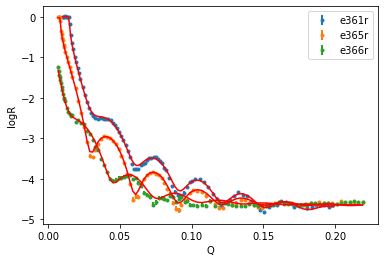

In [12]:
global_objective.plot()
plt.legend()
plt.xlabel('Q')
plt.ylabel('logR');

In [13]:
print(global_objective)

_______________________________________________________________________________

--Global Objective--
________________________________________________________________________________
Objective - 140332980321968
Dataset = e361r
datapoints = 99
chi2 = 564.3594634863424
Weighted = True
Transform = Transform('logY')
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=1.01677 +/- 0.00239, bounds=[0.9, 1.1]>
<Parameter:     'bkg'     , value=1.51604e-05 +/- 3.06e-07, bounds=[9e-09, 3e-05]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
__________________________________________________________

Now we're going to do some MCMC sampling. We discard the first 400 steps, then save 1 in every 100 steps, for a total of 30 saved steps.

In [14]:
fitter.sample(400, random_state=1)
fitter.sampler.reset()
fitter.sample(30, nthin=100, random_state=1);

100%|███████████████████████████████████████| 3000/3000 [11:26<00:00,  4.37it/s]


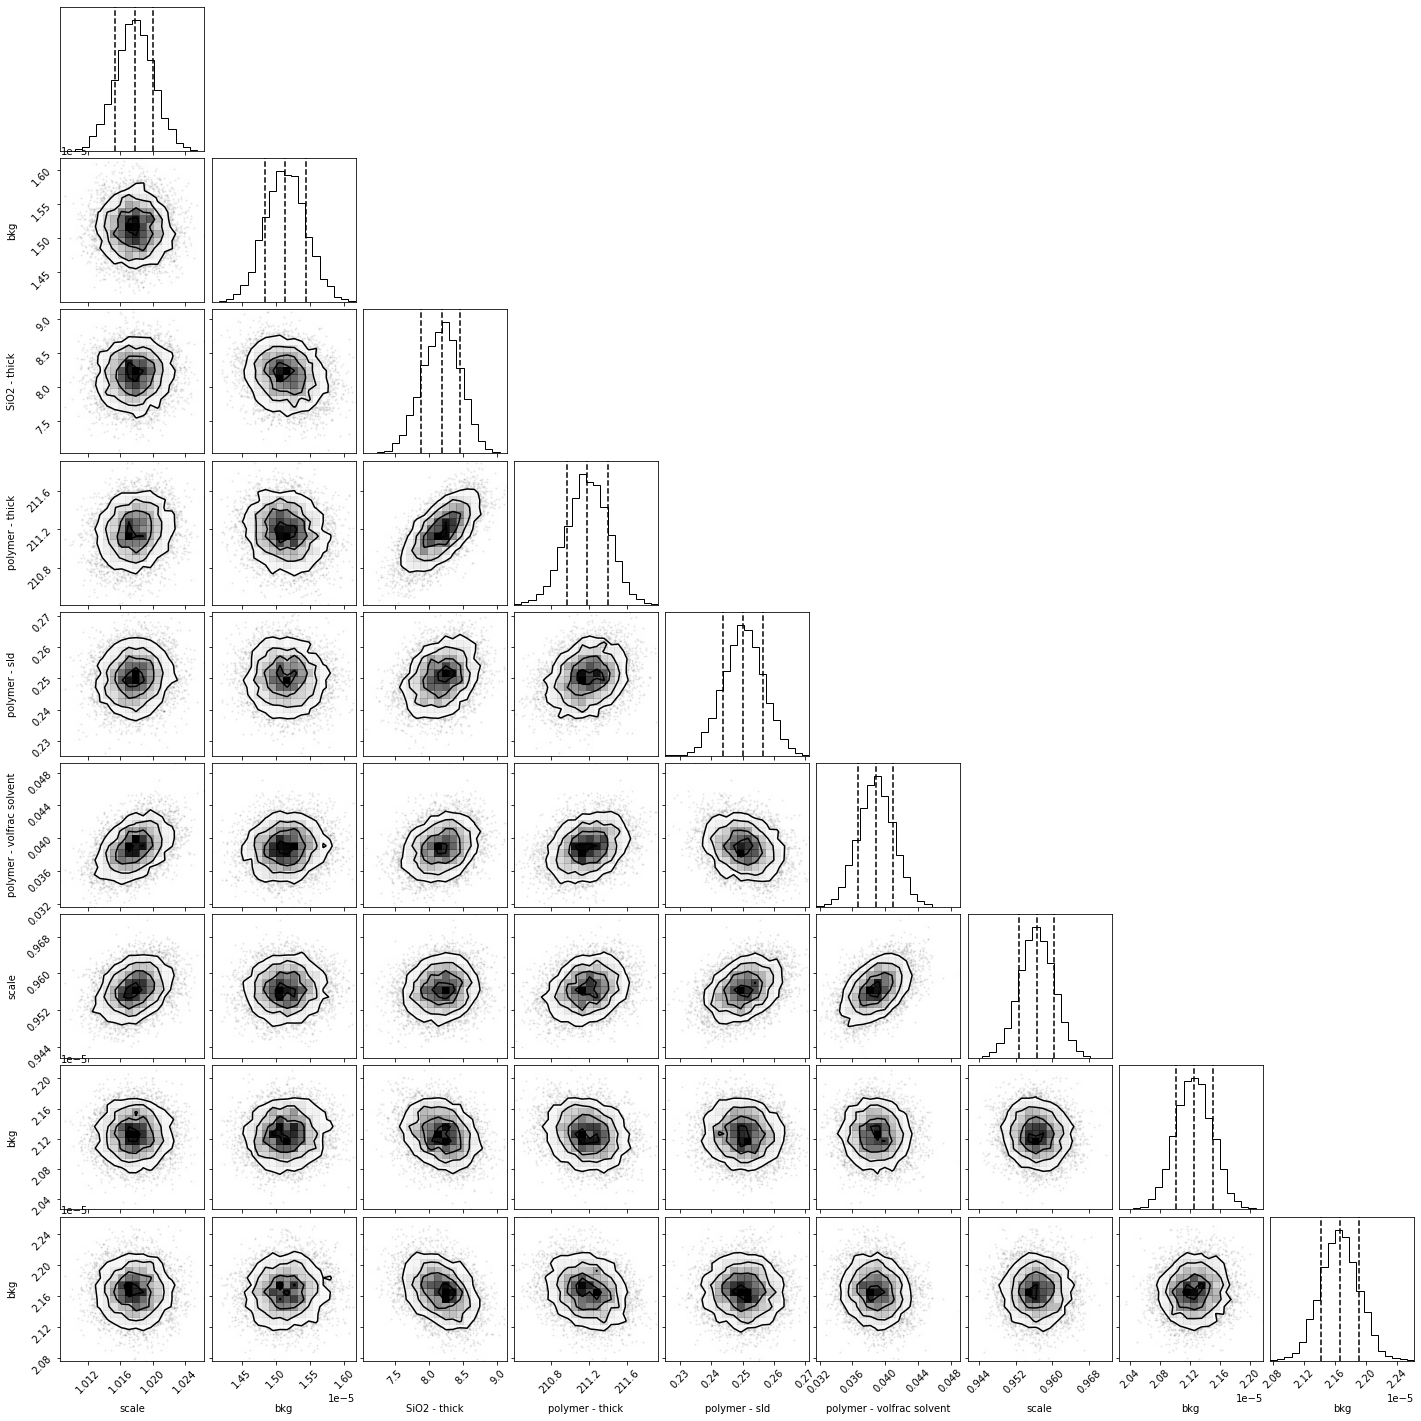

In [15]:
global_objective.corner();